Nous disposons d'un jeu de données sur 7 bouées dérivantes, de la forme :
"PLATFORM_CODE";"LOCATION_DATE";"LATITUDE";"LONGITUDE"

A partir de ces données, le but est de déterminer si certaines de ces bouées sont des doublons, auquel cas il faudrait les supprimer de la base de données.
Des analyses plus classiques sur les données de ces bouées seront ensuite entreprises, après la purification du jeu de données.

Nous importons le module cartopy, que nous avons installé via conda, pour tracer les trajectoires des bouées sur une carte.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
url = "drifter-2.dsv"
data = pd.read_csv(url)

# Display the first lines of the dataframe
data.head()

,,"PLATFORM_CODE;""LOCATION_DATE"";""LATITUDE"";""LONGITUDE"""
11923;01/10/2006 15:27:00;11,781;52,636.0
11923;01/10/2006 06:04:00;11,5;52,348.0
11923;01/10/2006 02:46:00;11,5;52,348.0
11923;02/10/2006 08:41:00;11,734;53,16.0
11923;30/09/2006 19:03:00;11,278;52,265.0


Ici, pour la première ligne par exemple, la latitude est 45.233 ° et la longitude est 775.0 °.

In [2]:
data.columns[0]

'PLATFORM_CODE;"LOCATION_DATE";"LATITUDE";"LONGITUDE"'

On se rend compte qu'il y a un problème avec le jeu de données : il n'y a qu'une colonne, les informations ne sont pas triées.

In [3]:
data.values[:5]

array([[636.],
       [348.],
       [348.],
       [ 16.],
       [265.]])

In [4]:
data.index[:5]

MultiIndex([('11923;01/10/2006 15:27:00;11', '781;52'),
            ('11923;01/10/2006 06:04:00;11',   '5;52'),
            ('11923;01/10/2006 02:46:00;11',   '5;52'),
            ('11923;02/10/2006 08:41:00;11', '734;53'),
            ('11923;30/09/2006 19:03:00;11', '278;52')],
           )

In [5]:
[data.index[0][0], data.index[0][1]]

['11923;01/10/2006 15:27:00;11', '781;52']

La plupart des données sont stockées avec les index. Un grand travail de réorganisation s'impose.
Dans un premier temps, nous optons pour une approcher "manuelle" :
Nous essayons de repasser par des tableaux numpy pour créer avec des dictionnaires une nouvelle dataframe propre.

Après quelques tentatives infructueuses, la documentation de pandas nous montre une méthode pour agencer proprement les données directement.

In [6]:
csv_file = 'drifter-2.dsv'
delimiter = ';'
decimal_separator = ','

# Read the CSV file into a DataFrame, specifying the decimal separator
df = pd.read_csv(csv_file, sep=delimiter, decimal=decimal_separator)

df.head()

,PLATFORM_CODE,LOCATION_DATE,LATITUDE,LONGITUDE
0,11923,01/10/2006 15:27:00,11.781,52.636
1,11923,01/10/2006 06:04:00,11.500,52.348
2,11923,01/10/2006 02:46:00,11.500,52.348
3,11923,02/10/2006 08:41:00,11.734,53.160
4,11923,30/09/2006 19:03:00,11.278,52.265


In [7]:
unique_values = df['PLATFORM_CODE'].unique()
print(unique_values)

# Make the expression of date times more regular
df['LOCATION_DATE'] = pd.to_datetime(df['LOCATION_DATE'], dayfirst = True)
df.head()

['11923' '15623' '62456' 'EXD05216' 'EXD06882' 'IF000051' 'IF000053']


,PLATFORM_CODE,LOCATION_DATE,LATITUDE,LONGITUDE
0,11923,2006-10-01 15:27:00,11.781,52.636
1,11923,2006-10-01 06:04:00,11.500,52.348
2,11923,2006-10-01 02:46:00,11.500,52.348
3,11923,2006-10-02 08:41:00,11.734,53.160
4,11923,2006-09-30 19:03:00,11.278,52.265


Nous voici avec un dataframe bien rangé. Avant d'analyser les données, nous traçons les trajectoires pour les visualiser.

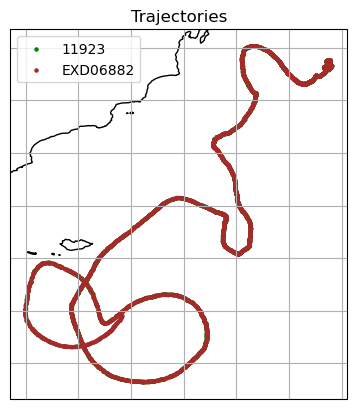

In [8]:
# Create a map using Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Define colors for each trajectory based on unique values in 'platform_code' column
colors = {'11923': 'green', '15623': 'black', '62456': 'blue', 'EXD05216': 'orange', 'EXD06882': 'brown', 'IF000051': 'red', 'IF000053': 'yellow'}
# Plot the latitude and longitude data on the map
for platform, group in df.groupby('PLATFORM_CODE'):
    if platform in ['11923', 'EXD06882']:
        sizes = [5 for _ in range(len(group))]
        ax.scatter(group['LONGITUDE'], group['LATITUDE'], label=platform, color=colors[platform], s=sizes)

# Add additional map features (e.g., coastlines, gridlines)
ax.coastlines()
ax.gridlines()

# Set labels and title
ax.set_xlabel('LONGITUDE')
ax.set_ylabel('LATITUDE')
ax.set_title('Trajectories')

# Show the plot
plt.legend()
plt.show()

Procédure de détection des doublons :

1) 

In [9]:
df.head()

,PLATFORM_CODE,LOCATION_DATE,LATITUDE,LONGITUDE
0,11923,2006-10-01 15:27:00,11.781,52.636
1,11923,2006-10-01 06:04:00,11.500,52.348
2,11923,2006-10-01 02:46:00,11.500,52.348
3,11923,2006-10-02 08:41:00,11.734,53.160
4,11923,2006-09-30 19:03:00,11.278,52.265


In [10]:
# On considère deux bouées b1 et b2 que l'on sait identique. 
# Le but est de caractériser les écarts de coordonnées entre b1 et b2,
# et d'en déduire une méthode générale permettant de dire avec un faible taux d'erreur si deux bouées sont des doublons ou non.

# Il faut distinguer les deux cas suivants :
# 1) deux bouées sont proches mais disctinctes
# 2) un doublon

# Plus concrètement, nous allons afficher le graphe y = f(x), où f(x) est le nombre de dates où l'écart angulaire x a été enregistré entre b1 et b2.
# Le but est de déduire un écart-type de la variation de coordonnées pour une même date pour les deux bouées du doublon.

# Arguments : x1 = (long1, lat1) et x2 = (long2, lat2)
# Sortie : angle x1-(centre terre)-x2 (en première approximation)
def dist(x1,x2):
    long1, lat1 = x1
    long2, lat2 = x2
    return ( (long2 - long1)**2 + (lat2 - lat1)**2 ) ** 0.5

# Pour la fonction suivante, nous avons essayé de travailler avec groupby, mais cela ne fonctionnait pas (messages d'erreur que nous n'avons pas compris)
# Nous changeons donc de méthode.

# Arguments : numéros des plateformes des deux bouées à comparer
# Sortie : renvoie deux dataframe, un pour chacune des bouées, 
# triés par date, avec uniquement les lignes correspondant à leur période de coexistence, et avec en index la date.
def get_data(b1, b2):
    bouee1 = df['PLATFORM_CODE'] == b1
    bouee2 = df['PLATFORM_CODE'] == b2
    data1 = df[bouee1].copy()
    data2 = df[bouee2].copy()
    
    start1, start2 = data1['LOCATION_DATE'].min(), data2['LOCATION_DATE'].min()
    start = max(start1, start2)  # on commence au début de la période d'activité commune
    end1, end2 = data1['LOCATION_DATE'].max(), data2['LOCATION_DATE'].max()
    end = min(end1, end2)  # on s'arrête dès qu'une des "deux" bouées n'envoie plus de signal
    
    # On tronque les df entre ces deux dates.
    s1 = start <= data1['LOCATION_DATE']
    e1 = data1['LOCATION_DATE'] <= end
    s2 = start <= data2['LOCATION_DATE']
    e2 = data2['LOCATION_DATE'] <= end
    data1 = data1[s1 & e1]
    data2 = data2[s2 & e2]
   
    # Maintenant, on trie les mesures par date :
    data1 = data1.sort_values(by = 'LOCATION_DATE')
    data2 = data2.sort_values(by = 'LOCATION_DATE')

    # puis on la met en index
    data1 = data1.set_index('LOCATION_DATE')
    data2 = data2.set_index('LOCATION_DATE')
    
    return data1, data2

In [11]:
# Dans la documentation qui accompagne ces données, on sait que '11923' et 'EXD06882' correspondent à la même bouée.
# La carte de trajectoires ci-dessus le laisse penser.
get_data('11923', 'EXD06882')

(                    PLATFORM_CODE  LATITUDE  LONGITUDE
 LOCATION_DATE                                         
 2006-09-27 17:16:00         11923     8.805     52.938
 2006-09-27 18:32:00         11923     8.836     52.885
 2006-09-27 18:54:00         11923     8.836     52.885
 2006-09-28 02:20:00         11923     8.954     52.662
 2006-09-28 02:40:00         11923     8.986     52.614
 ...                           ...       ...        ...
 2007-01-24 23:40:00         11923    19.170     63.529
 2007-01-25 00:16:00         11923    19.167     63.533
 2007-01-25 01:42:00         11923    19.160     63.529
 2007-01-25 01:57:00         11923    19.157     63.530
 2007-01-25 04:49:00         11923    19.157     63.530
 
 [3146 rows x 3 columns],
                     PLATFORM_CODE  LATITUDE  LONGITUDE
 LOCATION_DATE                                         
 2006-09-27 18:31:32      EXD06882   8.83042   52.89453
 2006-09-27 20:14:44      EXD06882   8.86187   52.83585
 2006-09-27 22:12:16

Nous sommes confrontés à un problème. Nous pensions que les mesures de coordonnées étaient faites deux fois (une fois pour chaque élément du doublon) au même moment. En réalité, il y a un écart temporel, ce qui rend plus difficile de tracer le graphe de f.
Pour contourner le problème, nous allons considérer qu'entre deux mesures, la bouées suit une trajectoire rectiligne uniforme.

In [12]:
# On commence par créer un nouveau dataframe data2 qui contient les coordonnées de b2 aux dates explicites de data1,
# déduites grâce au procédé décrit ci-dessus.
def add12(data1, data2):
    d = {'PLATFORM_CODE' : [] , 'LOCATION_DATE' : [], 'LATITUDE' : [], 'LONGITUDE': []}
    plat2 = data2['PLATFORM_CODE'].unique()[0]
    for DATE in data1.index :
        date = pd.Timestamp(DATE)
        day = str(date.date())
        print(day)
        datajour = data2.loc[day]
        # first date before
        datajouravant = datajour[datajour.index <= date]
        if len(datajouravant) != 0:
            coordavant = datajouravant.tail(1)
        else : 
            date_before = pd.Timestamp(date - pd.DateOffset(days=1))
            day_before = str(date_before.date())
            datahier = data2.loc[day_before]
            coordavant = datahier.tail(1)

        # first date after
        datajourapres = datajour[datajour.index > date]
        if len(datajourapres) != 0:
            coordapres = datajourapres.head(1)
        else : 
            date_after = pd.Timestamp(date + pd.DateOffset(days=1))
            day_after = str(date_after.date())
            datademain = data2.loc[day_after]
            coordapres = datademain.head(1)

        avancee = (date - coordavant.index) / (coordapres.index - coordavant.index)
        long = coordavant['LONGITUDE'] * (1 - avancee) + avancee * coordapres['LONGITUDE']
        lat = coordavant['LATITUDE'] * (1 - avancee) + avancee * coordapres['LATITUDE']

        d['PLATFORM_CODE'].append(data2)
        d['LOCATION_DATE'].append(date)
        d['LONGITUDE'].append(long)
        d['LATITUDE'].append(lat)

        return pd.DataFrame(d)
    
# Arguments : les deux dataframes correspondant aux deux bouées, avec les mêmes dates
# Sortie : le graphe décrit
def f(data1, data2):
    Ecart = []
    for date in data1.index :
        x1 = data1[date]['LONGITUDE'], data1[date]['LATITUDE']
        x2 = data2[date]['LONGITUDE'], data2[date]['LATITUDE']
        ecart = dist(x1, x2)
        Ecart.append(ecart)
    Ecart.sort()
    xmin = Ecart[0]
    xmax = Ecart[-1]
    N = 10000
    step = xmax/N
    x = np.linspace(0, xmax, N)
    y = np.zeros(N)
    for ecart in Ecart:
        y[(ecart * N / xmax)//1] += 1
    plt.plot(x, y)
    plt.show()

    # on peut éventuellement (rien à réécrire) changer data 1 et data2 pour avoir un graphe qui est censé ressembler (check méthode)

In [13]:
data1, data2 = get_data('11923', 'EXD06882')
data2 = add12(data1, data2)
f(data1, data2)

2006-09-27


KeyError: '2006-09-26'

On déduit une distance caractéristique au-delà de laquelle il est peu probable que deux bouées soient identiques (pour une certaine durée au delà de cette distance).

Si la courbe est une belle gaussienne, on pourra peut-être affiner le critère de manière précise, avec une minoration ou une majoration de la probabilité de deux bouées sont un doublon.
Pour conclure, il faudrait se pencher sur les points suivants :
1) La méthode fonctionne-t-elle ?
2) Comment on pourrait l'améliorer ? (plus d'échantillonage, différencier les drifters en fonction de leur type : plus ou moins précis)
3) politique future des bouées : leur donner une clé d'identification qu'elles envoient avec chaque mesure